# Benchmarking Qmachines with different RB protocols

In [1]:
from RB_stabilizer_verification import machine_response_stabilizer_bench
from RB_standard_verification import machine_response_standard_bench
from RB_with_Rigetti_native_gates import machine_response_srb_native_gate
from RB_with_Rigetti_native_gates_conditional_probability import machine_response_rb_native_gate_conditional
from RB_standard_verification_with_arbitrary_random_unitaries import machine_response_standard_bench_random_units
from RB_with_Rigetti_native_gates_conditional_probability_two_qubits import machine_response_rb_universal_two_qubits_conditional

from functions import *
from pyquil import get_qc
from pyquil import noise

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [3]:
from scipy.optimize import curve_fit

In [4]:
from csv import writer
from datetime import datetime

In [5]:
k_m = 50 #number of sequences
n_m = 50 #number of shots
n_qubit = 2

qmachine = get_qc( str(n_qubit) + "q-qvm" )
# qmachine = get_qc("9q-square-noisy-qvm")
# qmachine = get_qc("9q-square-noisy-qvm")
# qmachine = get_qc( str(n_qubit) + 'q-qvm')  # You can make any 'nq-qvm'
# qmachine = get_qc('Aspen-11',execution_timeout=60, compiler_timeout=100)

### Depolarising noise in terms of pauli channels
$$ \Lambda_{dep}(\rho) = (1-3\lambda/4)\rho + \lambda/4 X^{\dagger}\rho X + \lambda/4 Y^{\dagger}\rho Y + \lambda/4 Z^{\dagger}\rho Z $$

$$ \Lambda_{dep}(\rho) = (1-\epsilon)\rho + \frac{\epsilon}{d} I $$

So if we want to have a depolarising noise channel with $\epsilon = 0.0001$, we should define it with taking into account that $p_i = \frac{\epsilon}{4} $. So it gives

$p_i \approx 0.000025 $

In [6]:
epsilon = 0.01
p_xi = epsilon/4
qmachine.qam.gate_noise=(p_xi,p_xi,p_xi)
# qmachine.qam.gate_noise=(0,0,p_xi)

In [7]:
noise_model = 'depolarising_noise'
# noise_model = 'z_noise'
path = os.path.join( os.getcwd(), 'output_storage', noise_model, 'epsilon{}'.format(epsilon) )
try:
    os.makedirs( path )
except:
    pass

In [8]:
ordered_layers = np.arange(0,50,5).astype('int')
max_layer_num = ordered_layers[-1]

ordered_layers_arr = np.array( ordered_layers )
between_layers = np.arange(ordered_layers_arr.min(),ordered_layers_arr.max()+1,1).astype('int')

# np.save( os.path.join(path, 'layers_indices.npy'), ordered_layers_arr )

bench_protocol_func_dict = {'standard':machine_response_standard_bench,
                            'native':machine_response_srb_native_gate,
                            'native_conditional':machine_response_rb_native_gate_conditional,
                            'stabilizer':machine_response_stabilizer_bench,
                            'random_def_unitaries':machine_response_standard_bench_random_units,
                           'conditional_universal_circuit':machine_response_rb_universal_two_qubits_conditional}

In [9]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [10]:
file_path = os.path.join(path, '{}.csv'.format(qmachine.name))
if os.path.isfile(file_path):
    pass
else:
    with open(file_path, 'w') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(['date', 'number of qubits', 'number of sequences', 'number of shots',
                                'protocol name', 'circuit depth', 'average of fidelity', 'error of fidelity'])
        f_object.close()

In [11]:
def record_this_layer(protocol_name:str, qmachine, depth:int, fidelity_average, fidelity_err):
    List = [datetime.today().strftime('%Y-%m-%d'), n_qubit, k_m, n_m,
            protocol_name, depth, fidelity_average, fidelity_err]
    file_path = os.path.join(path, '{}.csv'.format(qmachine.name))
    with open(file_path, 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()
    return

def bench_machine(protocol_name:str, qmachine, n_qubit:int, k_m:int, n_m:int):
    bench_protocol_func = bench_protocol_func_dict[protocol_name]
    avg_fdlty_list = []
    err_fdlty_list = []
    
    for m in tqdm(ordered_layers):
        response = bench_protocol_func(qmachine, n_qubit, m, k_m, n_m)
        record_this_layer(protocol_name, qmachine, m, averageOfFidelity(response), stdOfFidelity(response))
        
        avg_fdlty_list.append( averageOfFidelity(response) )
        err_fdlty_list.append( stdOfFidelity(response) )
    return np.array(avg_fdlty_list), np.array(err_fdlty_list)

## RB standard version (with Clifford set)

In [12]:
avg_std_fdlty_arr, err_std_fdlty_arr = bench_machine('standard', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.83s/it]


In [13]:
# popt_std, pcov_std = extrapolate_decay_func(avg_std_fdlty_arr, err_std_fdlty_arr)
plot_decay(ordered_layers_arr, avg_std_fdlty_arr, err_std_fdlty_arr, 'std_clifford')

## RB stabilizer version (with Clifford set)

In [14]:
avg_stab_fdlty_arr, err_stab_fdlty_arr = bench_machine('stabilizer', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.12s/it]


In [15]:
popt_stab, pcov_stab = extrapolate_decay_func(avg_stab_fdlty_arr, err_stab_fdlty_arr)
plot_decay(ordered_layers_arr, avg_stab_fdlty_arr, err_stab_fdlty_arr, 'stabilizer_clifford')

## RB standard version (with Riggetti native gate set)

In [16]:
avg_native_fdlty_arr, err_native_fdlty_arr = bench_machine('native', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.69s/it]


In [17]:
# popt_native, pcov_native = extrapolate_decay_func(avg_native_fdlty_arr, err_native_fdlty_arr)
plot_decay(ordered_layers_arr, avg_native_fdlty_arr, err_native_fdlty_arr, 'random_native_gates')

## RB standard version (with arbitary random unitary set)

In [18]:
avg_runitary_fdlty_arr, err_runitary_fdlty_arr = bench_machine('random_def_unitaries', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.12s/it]


In [19]:
# popt_runitary, pcov_runitary = extrapolate_decay_func(avg_runitary_fdlty_arr, err_runitary_fdlty_arr)
plot_decay(ordered_layers_arr, avg_runitary_fdlty_arr, err_runitary_fdlty_arr, 'random_unitary_gates')

# single-qubit RB with conditional prob. on native gates

In [20]:
avg_cond_fdlty_arr, err_cond_fdlty_arr = bench_machine('native_conditional', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.88s/it]


In [21]:
popt_cond, pcov_cond = extrapolate_decay_func(avg_cond_fdlty_arr, err_cond_fdlty_arr)
plot_decay(ordered_layers_arr, avg_cond_fdlty_arr, err_cond_fdlty_arr, 'native_gates_conditional')

# RB with conditional prob. on two qubits

In [22]:
avg_cond_fdlty_arr, err_cond_fdlty_arr = bench_machine('conditional_universal_circuit', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:52<00:00, 77.20s/it]


In [23]:
popt_cond, pcov_cond = extrapolate_decay_func(avg_cond_fdlty_arr, err_cond_fdlty_arr)
plot_decay(ordered_layers_arr, avg_cond_fdlty_arr, err_cond_fdlty_arr, ' conditional_universal_circuit')

## Diamond distance

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


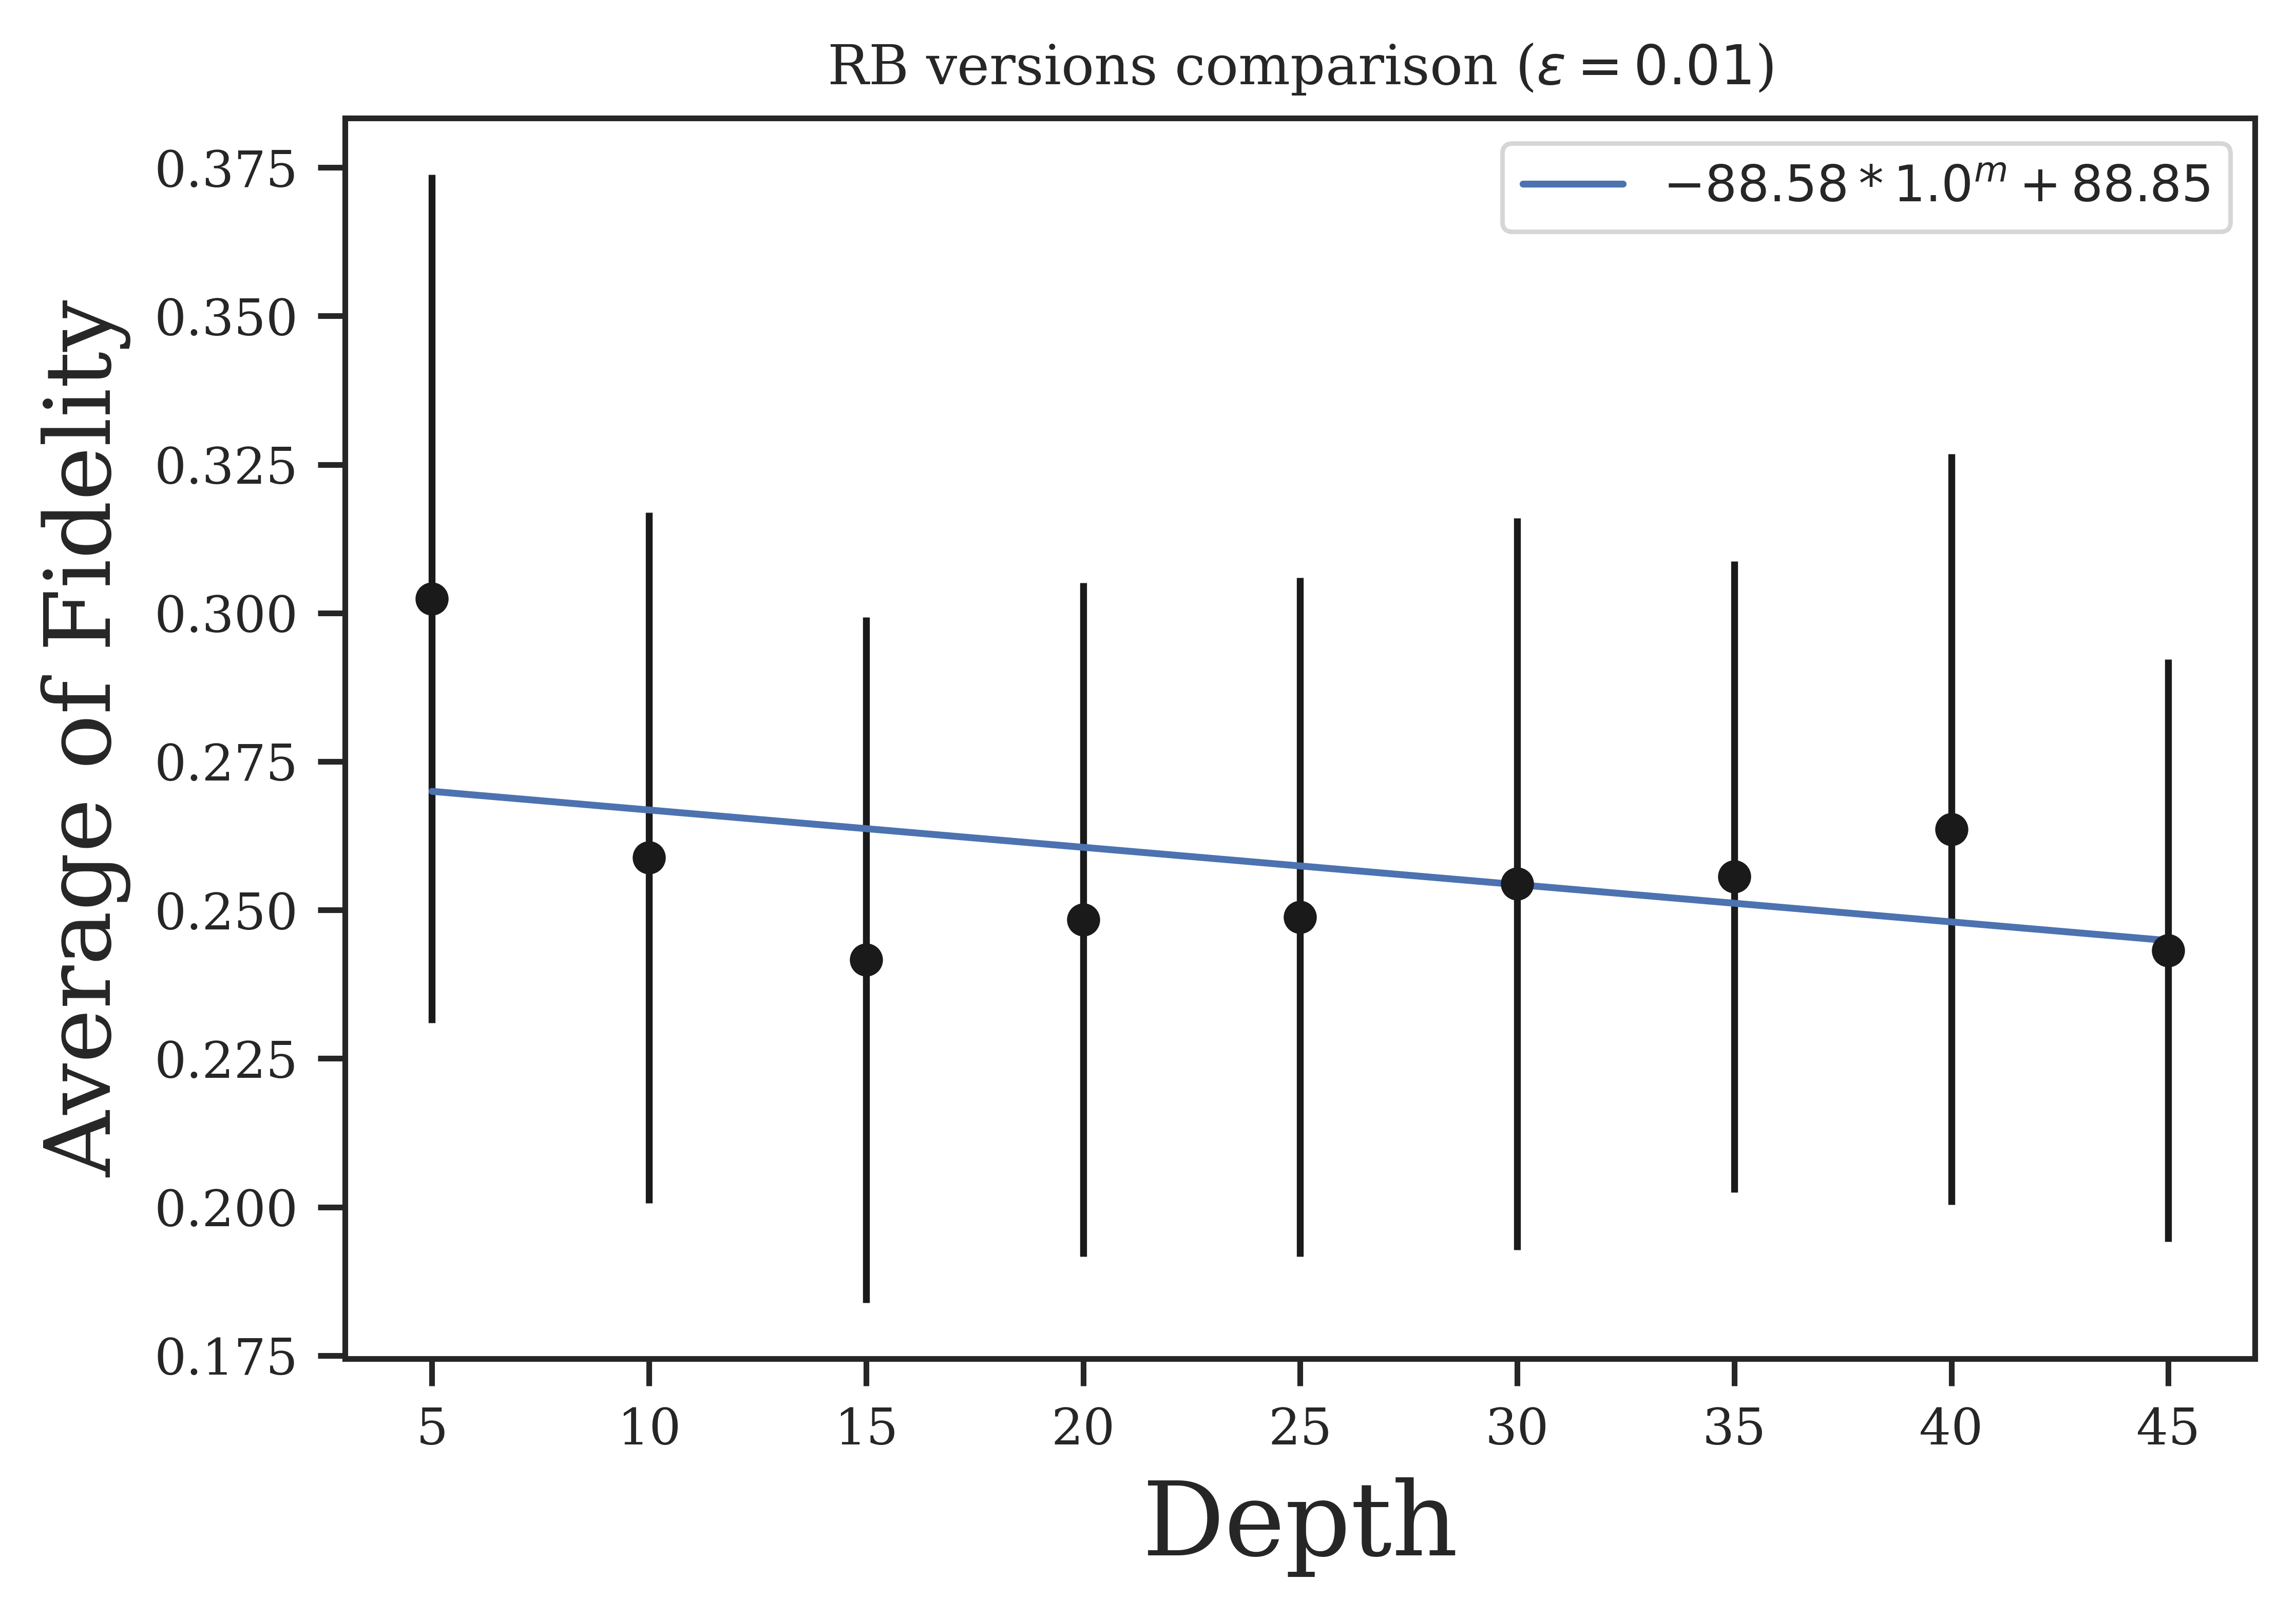

In [26]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

plot_decay(ordered_layers_arr[1:], avg_cond_fdlty_arr[1:], err_cond_fdlty_arr[1:],
           ' conditional_universal_circuit', axes = ax)

plt.xlabel('Depth', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'RB versions comparison ($\epsilon = {}$)'.format(epsilon))

plt.legend()

# fig.savefig('RB_comparison.png')

r parameter for Native gateset

In [25]:
decay_param(popt_native[0], n_qubit)

NameError: name 'popt_native' is not defined

r parameter for Clifford gateset

In [ ]:
decay_param(popt_std[0], n_qubit)

r parameter for Native benchmarking new method!

In [ ]:
decay_param(popt_cond[0], n_qubit)

In [27]:
print(Program(H(0), CNOT(0,1)))

H 0
CNOT 0 1



In [ ]:
'sknvnslnvw09050824'